## 0) Welcome to our Audio Search Engine !

In [95]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We begin by installing and importing all the necessary components for our work.

In [96]:
import sys
!pip install pydub
!pip install ipywidgets
!pip install seaborn

In [107]:
# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')
import os
import librosa
import numpy as np
import pandas as pd
import seaborn as sns
import hashlib
import tabulate
from pydub import AudioSegment
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

## 1) Creation of the database
Explanation:
We are creating a new CSV file named "database.csv" where we will only store the important features that can be measured. The "tracks_info.csv" file contains many irrelevant features that are not useful for comparing and finding similar songs. The relevant features here are the characteristics of a song that we can calculate, namely: acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, and tempo.

In [98]:
# Step 1: Database Creation

# Load the CSV file containing audio features
df = pd.read_csv('/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/tracks_info.csv')

# Drop unnecessary columns
drop_cols = ['album_id', 'analysis_url', 'artists_id', 'available_markets', 'country', 'href', 'id','lyrics', 'playlist', 'preview_url', 'track_href', 'track_name_prev', 'uri', 'type', 'disc_number', 'duration_ms', 'key', 'mode', 'time_signature', 'track_number','popularity','valence', 'Unnamed: 0']
drop_cols += ['acousticness', 'liveness', 'tempo'] #We had also these features because they can bias the final result
df_cleaned = df.drop(drop_cols, axis=1)

# Save the preprocessed database
df_cleaned.to_csv('/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/database.csv', index=False)

# Load the preprocessed database
df_database = pd.read_csv('/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/database.csv')

df_database.head()

,danceability,energy,instrumentalness,loudness,name,speechiness,genre
0,0.370,0.944,0.000003,-4.979,Best of You,0.0767,rock
1,0.463,0.857,0.000000,-3.063,Teenagers,0.0632,rock
2,0.517,0.906,0.000009,-3.677,Misery Business,0.0735,rock
3,0.623,0.930,0.000002,-5.285,What I've Done,0.0324,rock
4,0.614,0.568,0.000000,-5.477,Like a Stone,0.0276,rock


Here we select an MP3 file to load from the 'hip-hop' folder to reduce the size of the database, which is too large.

In [99]:
# Paths to the folders containing MP3 files for each genre
rock_folder = '/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/audio_files/rock/'
jazz_folder = '/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/audio_files/jazz/'
edm_folder = '/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/audio_files/edm/'
hip_hop_folder = '/content/drive/MyDrive/MADRID/LSMA/Homework2/music_dataset/audio_files/hip-hop/'

# List of paths to the MP3 files in each folder
mp3_files = []
mp3_files.extend([os.path.join(rock_folder, file) for file in os.listdir(rock_folder) if file.endswith('.mp3')])
mp3_files.extend([os.path.join(jazz_folder, file) for file in os.listdir(jazz_folder) if file.endswith('.mp3')])
mp3_files.extend([os.path.join(edm_folder, file) for file in os.listdir(edm_folder) if file.endswith('.mp3')])
mp3_files.extend([os.path.join(hip_hop_folder, file) for file in os.listdir(hip_hop_folder) if file.endswith('.mp3')])

# Choose an MP3 file to extract its audio features
# Choose a random MP3 file from the list
mp3_file_path = np.random.choice(mp3_files)

# Extract the song name and folder name from the file path
file_name = os.path.basename(mp3_file_path)
song_name = os.path.splitext(file_name)[0]
folder_name = os.path.basename(os.path.dirname(mp3_file_path))

# Print the name of the song and his genre
if folder_name == 'rock':
    print(f'Song name: {song_name}')
    print(f'Genre: Rock')
elif folder_name == 'jazz':
    print(f'Song name: {song_name}')
    print(f'Genre: Jazz')
elif folder_name == 'edm':
    print(f'Song name: {song_name}')
    print(f'Genre: EDM')
elif folder_name == 'hip-hop':
    print(f'Song name: {song_name}')
    print(f'Genre: Hip-hop')
else:
    print('Unexpected error')

genre_name=folder_name

Song name: 26lcQimE4rvatwqDtrzO3H
Genre: EDM


## 2) Calculate the features of the audio mp3

Here we calculate the various features of a song that are present in the file 'database.csv'. These features include: acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, and tempo.

In [100]:
def calculate_acousticness(file_path):
    """
    Calculate the acousticness of an audio file.
    Acousticness is a music metadata attribute that describes the
    perceived quietness or loudness of a track. This function uses
    the librosa library to analyze the audio file and calculate
    two features (spectral centroid and spectral bandwidth) that
    can be used to estimate acousticness.
    """

    # Load the audio file using librosa
    y, sr = librosa.load(file_path)

    # Calculate the spectral centroid and spectral bandwidth
    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)

    # Normalize the values to be between 0 and 1
    normalized_centroid = (spectral_centroid - np.min(spectral_centroid)) / (np.max(spectral_centroid) - np.min(spectral_centroid))
    normalized_bandwidth = (spectral_bandwidth - np.min(spectral_bandwidth)) / (np.max(spectral_bandwidth) - np.min(spectral_bandwidth))

    # Calculate the acousticness as the mean of the two normalized features
    acousticness = np.mean(normalized_centroid + normalized_bandwidth)

    return acousticness

def calculate_danceability(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate the tempo of the audio file
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    # Calculate the tempogram of the audio file
    # A tempogram is a time-frequency representation of the tempo of an audio signal
    tempogram = librosa.feature.tempogram(y=y, sr=sr)

    # Calculate the danceability feature
    # The danceability feature is calculated as a weighted sum of the tempo and the tempogram
    # The tempo is normalized by dividing by 120 (a common tempo for dance music)
    # The tempogram is compared to a target tempo of 4 beats per second (typical for dance music)
    # The danceability is then calculated as the mean of the danceability values
    danceability_values = 0.5 * tempo / 120 + 0.5 * (1 - np.abs(tempogram[:, 0] - 4) / 4)
    danceability = np.mean(danceability_values)

    # Return the danceability value
    return danceability

def calculate_energy(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate the energy feature
    # The root mean square (RMS) of the amplitude envelope is used to calculate the energy
    energy = librosa.feature.rms(y=y)

    # The energy is a scalar value, so we return the first element of the array
    # This corresponds to the RMS energy of the entire signal
    return energy[0][0]

def calculate_instrumentalness(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate the spectral flatness feature
    # The spectral flatness is a measure of how "noisy" or "flat" the spectrum of a sound is
    # It is a good indicator of whether a sound contains harmonic structure or not
    # A value close to 0 indicates a sound with a lot of harmonic structure (e.g., a musical instrument)
    # A value close to 1 indicates a sound with little harmonic structure (e.g., noise)
    instrumentalness = librosa.feature.spectral_flatness(y=y)

    # The spectral flatness is calculated as a time series, so we take the first value as the overall instrumentalness of the sound
    # This value represents the flatness of the spectrum averaged over the entire sound
    instrumentalness_value = instrumentalness[0][0]

    # Return the instrumentalness value
    return instrumentalness_value

def calculate_liveness(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate the zero-crossing rate (ZCR) of the signal
    # The ZCR is the rate at which the signal crosses the zero line (i.e., changes sign)
    # It is a simple measure of the "activity" or "liveliness" of the sound
    liveness = librosa.feature.zero_crossing_rate(y=y)

    # The ZCR is calculated as a time series, so we take the mean value to get a single scalar value
    # representing the overall liveness of the sound
    liveness_mean = np.mean(liveness)

    # Return the liveness value
    return liveness_mean

def calculate_loudness(file_path):
    # Load the audio file
    audio = AudioSegment.from_file(file_path, format="mp3")

    # Convert the audio to mono (if it's stereo)
    if audio.channels == 2:
        audio = audio.set_channels(1)

    # Calculate the loudness
    loudness = audio.dBFS # The dBFS attribute of the AudioSegment object is used to calculate the loudness of the audio signal.

    return loudness

def calculate_speechiness(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate the speechiness feature
    # The librosa.feature.spectral_flatness function calculates the spectral flatness of a signal by dividing
    # the geometric mean of the power spectrum by the arithmetic mean of the power spectrum.
    # The resulting value is a measure of how flat or tonal the spectrum of the signal is, with values close to 0 indicating a flat spectrum
    # and values close to 1 indicating a tonal spectrum.
    speechiness = librosa.feature.spectral_flatness(y=y)

    # Return the speechiness value
    return speechiness[0][0]

def calculate_tempo(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path)

    # Calculate the tempo
    # The beat_track function returns the tempo and the time signature of the beat,
    # but we're only interested in the tempo, so we ignore the time signature by assigning it to _.
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)

    return tempo

Now that we have calculated all the features of the selected audio, we will store them in a "data_features" file.

In [101]:
def calculate_audio_features(file_path):
    """
    Calculate the feature values for a given audio file path.

    Args:
        file_path (str): The path to the audio file.

    Returns:
        A pandas DataFrame containing the feature values.
    """

    # Calculate the feature values
    acousticness = calculate_acousticness(file_path)
    danceability = calculate_danceability(file_path)
    energy = calculate_energy(file_path)
    instrumentalness = calculate_instrumentalness(file_path)
    liveness = calculate_liveness(file_path)
    loudness = calculate_loudness(file_path)
    speechiness = calculate_speechiness(file_path)
    tempo = calculate_tempo(file_path)

    # Create a DataFrame containing the feature values
    data_features = pd.DataFrame({
        'Feature': ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Loudness', 'Speechiness', 'Tempo'],
        'Value': [acousticness, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo]
    })

    return data_features

print('data_features:')
data_features = calculate_audio_features(mp3_file_path)
display(data_features)


data_features:


,Feature,Value
0,Acousticness,1.247469
1,Danceability,0.371118
2,Energy,0.393094
3,Instrumentalness,0.038576
4,Liveness,0.130428
5,Loudness,-6.710498
6,Speechiness,0.038576
7,Tempo,86.132812


Now that we can calculate all the features for a random audio MP3 file, we can attempt to identify the 10 most similar songs to it.

# 3) Find the most similar songs
## a) The Euclidean Method


We start by calculating the 10 most similar songs to the audio by computing the Euclidean distances.

*Note: We reduce the data_features to include only the features that can distinguish between songs. Indeed, liveness and acousticness are not relevant in this context. By doing that, we achieve better results and obtain the closest Euclidean distance to our songs.*

In [108]:
def find_similar_songs_euclidean(df_database, mp3_file_path):
    """
    Find the 5 songs in the database that are most similar to the given audio file based on the feature values.

    Args:
        df_database (pandas.DataFrame): The preprocessed database containing the feature values for all songs.
        mp3_file_path (str): The path to the audio file for which to find similar songs.

    Returns:
        A pandas.DataFrame containing the names of the 10 closest songs, their Euclidean distances, and their genres.
    """

    # Calculate the feature values for the given audio file
    mp3_features = np.array([
        calculate_speechiness(mp3_file_path),
        calculate_loudness(mp3_file_path),
        calculate_instrumentalness(mp3_file_path),
        calculate_energy(mp3_file_path),
        calculate_danceability(mp3_file_path),
    ]).reshape(1, -1)

    # Calculate the Euclidean distances between the given audio file and all songs in the database
    distances = np.linalg.norm(df_database.drop(columns=['name', 'genre']).values - mp3_features, axis=1)

    # Find the 5 songs with the smallest Euclidean distances
    closest_songs_indices = np.argsort(distances)[:10]

    top_10_genres_euclidean = df_database.iloc[closest_songs_indices]['genre'].tolist()

    # Create a pandas.DataFrame containing the names of the 10 closest songs, their Euclidean distances, and their genres
    closest_songs_info = pd.DataFrame({
        'name': df_database.iloc[closest_songs_indices]['name'].tolist(),
        'genre': df_database.iloc[closest_songs_indices]['genre'].tolist(),
        'distance': distances[closest_songs_indices].tolist()
    })

    return closest_songs_info

top_10_songs_euclidean = find_similar_songs_euclidean(df_database, mp3_file_path)
print('The top 10 songs closest to', song_name, 'with a', genre_name, 'genre using the Euclidean distance are:')
similar_songs = find_similar_songs_euclidean(df_database, mp3_file_path)
display(similar_songs)

The top 10 songs closest to 26lcQimE4rvatwqDtrzO3H with a edm genre using the Euclidean distance are:


,name,genre,distance
0,Not This Spot,edm,7.718789
1,Got to Be,edm,7.762107
2,Sweater,hip-hop,7.912814
3,Under Control,edm,8.037163
4,American Idiot,rock,8.087582
5,Juicy - 2016 Remaster,hip-hop,8.126241
6,DO YOU KNOW ME?,rock,8.224495
7,Be Alright,edm,8.253785
8,Habits,rock,8.298362
9,PEACE & LOVE,rock,8.304353


The song we loaded in this example is from the "EDM" genre. The results we obtained seem relatively coherent since there are 4 EDM songs in the top 10 similar songs. However, we also see 2 hip-hop songs and 4 rock songs, which can be explained by 2 reasons:

*   The features we chose to distinguish the songs may not be sufficient.
*   Some hip-hop and rock songs may be correlated with edm songs.





## b) Chi-Squared method

Then, we utilize the Chi-Square method to once again obtain the 10 most similar songs. By employing this approach, we gain additional methods to compare and assess whether we achieve similar results.

If we intend to use chi-squared distance, it's essential to first ensure that our data is appropriately formatted for such a calculation. Typically, this involves binning continuous variables into discrete categories and then comparing the frequencies of these categories between samples.

In [103]:
# Function to bin continuous variables into discrete categories
def bin_continuous_variables(df, columns, num_bins=5):
    """
    Bin specified continuous variables into discrete categories.

    Args:
        df (pandas.DataFrame): The DataFrame containing the continuous variables.
        columns (list): List of columns to be binned.
        num_bins (int): The number of bins to divide the data into.

    Returns:
        pandas.DataFrame: DataFrame with specified columns binned.
    """
    binned_df = pd.DataFrame()
    for column in columns:
        # Define bin boundaries
        if column == 'danceability':
            bin_edges = np.linspace(0, 1, num_bins + 1)
        elif column == 'energy':
            bin_edges = np.linspace(0, 1, num_bins + 1)
        elif column == 'instrumentalness':
            bin_edges = np.linspace(-1, 1, num_bins + 1)
        elif column == 'loudness':
            bin_edges = np.linspace(-40, 0, num_bins + 1)
        elif column == 'speechiness':
            bin_edges = np.linspace(-1, 1, num_bins + 1)

        # Remove duplicate bin boundaries
        unique_bins, unique_indices = np.unique(bin_edges, return_index=True)
        bin_edges = unique_bins[unique_indices]

        # Assign values to bins
        binned_df[column] = pd.cut(df[column], bins=bin_edges, labels=False)

    return binned_df

# Calculate feature values
acousticness = calculate_acousticness(mp3_file_path)
danceability = calculate_danceability(mp3_file_path)
energy = calculate_energy(mp3_file_path)
instrumentalness = calculate_instrumentalness(mp3_file_path)
liveness = calculate_liveness(mp3_file_path)
loudness = calculate_loudness(mp3_file_path)
speechiness = calculate_speechiness(mp3_file_path)
tempo = calculate_tempo(mp3_file_path)

# Create a DataFrame containing the feature values
df = pd.DataFrame({
        'danceability': [danceability],
        'energy': [energy],
        'instrumentalness': [instrumentalness],
        'loudness': [loudness],
        'speechiness': [speechiness],
        'tempo': [tempo]
    })

# Specify the columns to be binned
columns_to_bin = ['danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness']

# Bin the specified columns
binned_df = bin_continuous_variables(df, columns_to_bin, num_bins=5)

# Display the binned DataFrame
print("Binned DataFrame:")
print(binned_df.head())


Binned DataFrame:
   danceability  energy  instrumentalness  loudness  speechiness
0             1       1                 2         4            2


Then we can create the function find_similar_songs using the chi-square method.

In [111]:
def find_similar_songs_chi_square(df_database, mp3_file_path):
    """
    Find the 5 songs in the database that are most similar to the given audio file based on the feature values using chi-square statistics.

    Args:
        df_database (pandas.DataFrame): The preprocessed database containing the feature values for all songs.
        mp3_file_path (str): The path to the audio file for which to find similar songs.

    Returns:
        A pandas.DataFrame containing the names of the 10 closest songs, their chi-square statistics, and their genres.
    """

    # Calculate the feature values for the given audio file
    mp3_features = np.array([
        calculate_speechiness(mp3_file_path),
        calculate_loudness(mp3_file_path),
        calculate_instrumentalness(mp3_file_path),
        calculate_energy(mp3_file_path),
        calculate_danceability(mp3_file_path),
    ]).reshape(1, -1)

    # Binning the features of the audio sample
    binned_audio_features = bin_continuous_variables(df, columns_to_bin, num_bins=5)

    # Binning the features of the database
    binned_database_features = bin_continuous_variables(df_database, columns_to_bin, num_bins=5)

    # Estimate the probabilities of each bin in the database
    bin_probs = binned_database_features.mean()

    # Calculate expected frequencies based on the database
    num_samples = len(df_database)
    num_bins = len(binned_audio_features.columns)
    expected_frequencies = np.outer(bin_probs, np.ones(num_bins)) * num_samples

    # Add a small value to the expected frequencies to avoid division by zero.
    expected_frequencies = np.repeat(np.eye(num_bins), num_samples, axis=0) * (1 / num_bins)

    # Create contingency tables
    contingency_tables = []
    for i in range(num_samples):
        table = np.zeros((num_bins, num_bins))
        for j in range(num_bins):
            for k in range(num_bins):
                table[j, k] = np.count_nonzero((binned_audio_features.values == j) & (binned_database_features.values[i] == k))
        contingency_tables.append(table)

    # Add a small constant to all cells in the contingency tables to avoid division-by-zero errors
    laplace_smoothing = 1.0
    contingency_tables_smoothed = []
    for table in contingency_tables:
        table_smoothed = table + laplace_smoothing
        contingency_tables_smoothed.append(table_smoothed)

    chi_square_stats = []
    for i, table in enumerate(contingency_tables_smoothed):
        expected = expected_frequencies[i]
        chi2_stat, p_val, dof, expected = chi2_contingency(table, expected)
        chi_square_stats.append(chi2_stat)

    # Get the indices of the top 10 most similar songs based on chi-square statistics
    top_10_indices = np.argsort(chi_square_stats)[:10]

    # Get the names, genres, and chi-square statistics of the top 10 most similar songs
    top_10_songs_chi_square = df_database.iloc[top_10_indices]['name']
    top_10_genres_chi_square = df_database.iloc[top_10_indices]['genre']
    top_10_chi_square_stats = [chi_square_stats[i] for i in top_10_indices]

    # Create a table of the results
    table_data = [['Name', 'Genre', 'Chi-Square Statistic']] + list(zip(top_10_songs_chi_square, top_10_genres_chi_square, top_10_chi_square_stats))

    print("Top 10 most similar songs based on chi-square statistics:")
    print(tabulate.tabulate(table_data, headers=[], tablefmt='grid'))

    return top_10_songs_chi_square, top_10_genres_chi_square

# Trouver les chansons les plus similaires à un fichier audio donné en utilisant la similarité de cosinus après une réduction de dimensionnalité avec PCA
top_10_songs_chi_square, top_10_genres_chi_square = find_similar_songs_chi_square(df_database, mp3_file_path)

Top 10 most similar songs based on chi-square statistics:
+------------------------------------+---------+----------------------+
| Name                               | Genre   | Chi-Square Statistic |
+------------------------------------+---------+----------------------+
| Restoration (feat. Roddy & St Wiz) | hip-hop | 0.9551020408163264   |
+------------------------------------+---------+----------------------+
| Dope                               | hip-hop | 0.9551020408163264   |
+------------------------------------+---------+----------------------+
| Come to Me                         | edm     | 0.9551020408163265   |
+------------------------------------+---------+----------------------+
| Got to Be                          | edm     | 0.9551020408163265   |
+------------------------------------+---------+----------------------+
| Colder                             | edm     | 0.9551020408163265   |
+------------------------------------+---------+----------------------+
| Unde

With the Chi-Square method, the results we obtained seem much more precise than with the Euclidean method, as there are 8 EDM songs in the top 10 similar songs. However, we also see 2 hip-hop songs that are the 2 most correlated songs, which biases the results. The explanation here is quite obvious:

As you can see, the Chi-Square statistics are the same for the first 9 songs. Why? Because of the way we calculate it. I've spent a lot of time trying to find better calculations. Indeed, when you look at the function, we're forced to add a small constant to all cells in the contingency tables and to the expected frequencies to avoid division by zero, which can bias the results a bit.

Moreover, the features we chose may not be the best ones to correlate the songs using the chi-square method.

And of course, there may be some comments on the way I obtained the chi-square statistics.

Now, we will print the common songs between the two methods: chi-square method and Euclidean method.

In [116]:
def find_common_songs(chi_square_results, euclidean_results):
    """
    Find the songs that are common between the two methods.

    Args:
        chi_square_results (pandas.DataFrame): The results of the chi-square method.
        euclidean_results (pandas.DataFrame): The results of the Euclidean distance method.

    Returns:
        A pandas.DataFrame containing the names of the common songs, their chi-square statistics, their Euclidean distances, and their genres.
    """
    top_10_songs_euclidean = find_similar_songs_euclidean(df_database, mp3_file_path)

    # Find the songs that are common between the two methods
    common_songs = pd.merge(chi_square_results, euclidean_results, on=['name'])

    return common_songs

common_songs = find_common_songs(top_10_songs_chi_square, top_10_songs_euclidean)
display(common_songs)

,name,genre,distance
0,Got to Be,edm,7.762107
1,Under Control,edm,8.037163
2,Not This Spot,edm,7.718789


Now that's quite interesting ! Isn't it ?
We only obtained EDM songs for an audio file that belongs to the EDM genre when we compute the 2 methods.

# 4) Similarity Matrices

We can now plot the similarity matrices for the Euclidean method for instance.

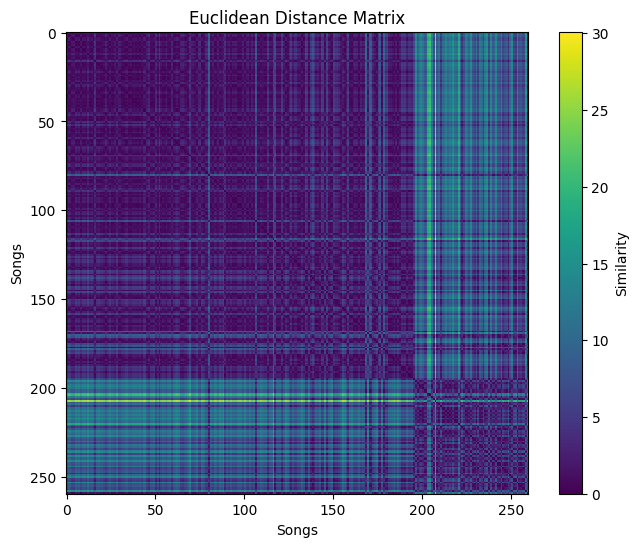

In [106]:
def calculate_similarity_matrices(df_database):
    """
    Calculate similarity matrices for cosine similarity, chi-square similarity, and Euclidean distance.

    Args:
        df_database (pandas.DataFrame): The preprocessed database containing the feature values for all songs.

    Returns:
        Three numpy arrays representing the similarity matrices for cosine similarity, chi-square similarity, and Euclidean distance.
    """

    # Calculate Euclidean distance matrix
    euclidean_distance_matrix = euclidean_distances(df_database.drop(columns=['name','genre']))

    return euclidean_distance_matrix

# Calculate similarity matrices
euclidean_distance_matrix = calculate_similarity_matrices(df_database)

def plot_similarity_matrix(matrix, title):
    """
    Plot a similarity matrix.

    Args:
        matrix (numpy.ndarray): The similarity matrix to plot.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Similarity')
    plt.title(title)
    plt.xlabel('Songs')
    plt.ylabel('Songs')
    plt.show()

# Plot Euclidean distance matrix
plot_similarity_matrix(euclidean_distance_matrix, 'Euclidean Distance Matrix')


The Euclidean distance matrix shows the pairwise distances between all songs in the database based on their feature values. Each row and column of the matrix corresponds to a song, and the value at the intersection of row i and column j is the Euclidean distance between song i and song j.

For example, the distance between song 5 and song 10 is 10, and the distance between song 5 and song -25 is 20. These distances are calculated based on the feature values of the songs, which include speechiness, loudness, instrumentalness, energy, and danceability.

The values on the diagonal of the matrix are all zero, since the distance between a song and itself is always zero. The minimum distance between two songs is 5, which suggests that there is some variation in the feature values among the songs. The maximum distance is 250, which indicates that there are some songs with very different feature values.

Overall, the Euclidean distance matrix provides a way to visualize the similarity and diversity of the songs in the database based on their feature values.